# Assignment 3 - part 2
Lauri Pessi | bft860

## Dataset: Yahoo finance: ETH-USD, BTC-USD

In [43]:
# Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from statsmodels.tsa.api import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.api import acf

plt.style.use('seaborn-whitegrid')

In [120]:
# Fetch data
df = pd.read_csv('http://myy.haaga-helia.fi/~menetelmat/Data-analytiikka/Teaching/beer.csv') 
df.index = pd.to_datetime(df['Month'],format="%Y-%m") 
df = df.drop('Month',axis=1) 
df.head()

,Monthly beer production
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9


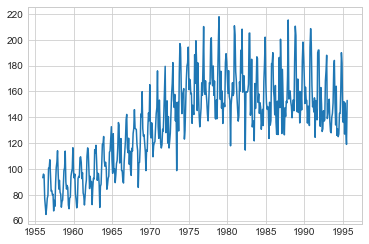

In [7]:
# Let's start by looking how the data looks like when plotted.
plt.plot(df)

## Initial assumptions
As expected the dataset seems to have both seasonal and trend elements, though the trend appears to follow some higher order function instead of being simply linear.
- My guess for the seasonality element is that production increases towards the summer.

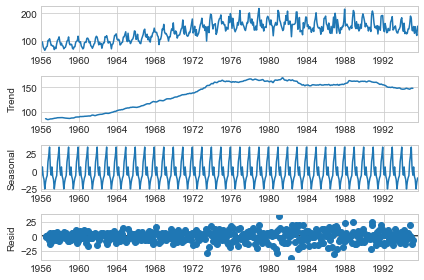

In [68]:
# Let's start by decomposing the seasonal, trend and noise elements of the series
comps = seasonal_decompose(df)

comps.plot(); # Semicolon-hack to fix duplicate output

Highest autocorrelation at the lags of:


array([ 0, 12, 24])

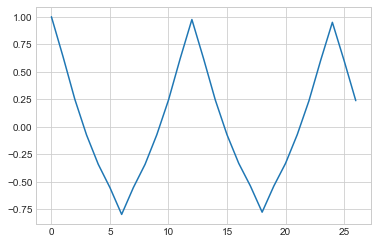

In [69]:
# While I'm expecting the seasonal trend being yearly, let's just make sure of it by calculating autocorrelations from the seasonal element 
lags = acf(comps.seasonal)

plt.plot(lags)
print('Highest autocorrelation at the lags of:')
np.flip(np.argsort(lags))[0:3]

In [121]:
# Taken that 0 is not useful input for seasonal_periods, let's use 12 which the second highest autocorrelation coefficent
model = ExponentialSmoothing(df, trend = 'add', seasonal = 'mul',
                             seasonal_periods = 12).fit()

model.summary()

# I ended up trying different combinations for trend and seasonal methods, but the first was the best by lowest SSE

# add, mul SSE: 44043.492
# add, add SSE: 46639.295
# mul, add SSE: 46684.738
# mul, mul SSE: 44132.249

/Users/lauripessi/miniconda3/envs/lauri-sandbox/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Dep. Variable:,Monthly beer production,No. Observations:,476
Model:,ExponentialSmoothing,SSE,44043.492
Optimized:,True,AIC,2187.097
Trend:,Additive,BIC,2253.744
Seasonal:,Multiplicative,AICC,2188.594
Seasonal Periods:,12,Date:,"Wed, 02 Mar 2022"
Box-Cox:,False,Time:,21:53:48
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.0841412,alpha,True
smoothing_trend,0.0841412,beta,True


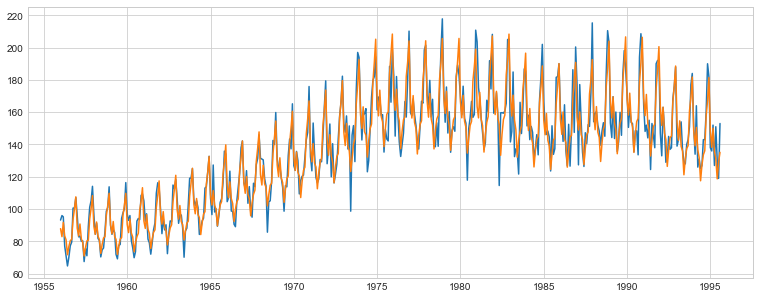

In [123]:
plt.figure(figsize=(13, 5))
df2 = df
df2['Forecast'] = model.fittedvalues
plt.plot(df2);

Text(0, 0.5, 'Forecast')

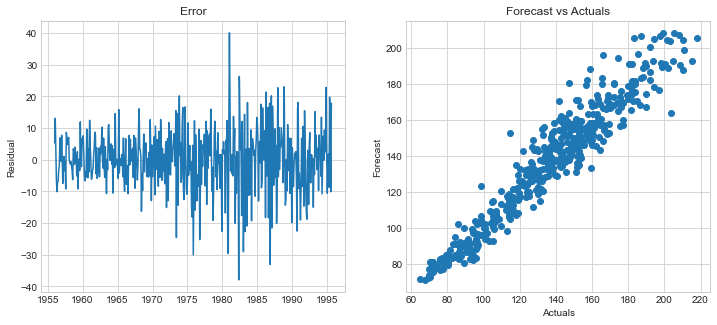

In [115]:
plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
plt.plot(model.resid)
plt.ylabel('Residual')
plt.title('Error')


plt.subplot(1,2,2)
plt.scatter(x=df, y=model.fittedvalues)
plt.title('Forecast vs Actuals')
plt.xlabel('Actuals')
plt.ylabel('Forecast')
